In [2]:
# Download nltk corpora required
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to /home/sherlock/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/sherlock/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/sherlock/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /home/sherlock/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [18]:
# Import required packages
import os
import uuid
import json
import numpy as np
import pandas as pd
from goose3 import Goose
from nltk import ne_chunk, pos_tag, word_tokenize
from nltk.tree import Tree
from newsapi import NewsApiClient
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from multiprocessing import Process, Queue
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
%matplotlib inline

In [70]:
# Constants for fetching news articles
news_sources = [
    'bbc-news',
    'vice-news',
    'the-guardian-uk',
    'independent',
    'the-economist',
    'the-telegraph',
    'the-new-york-times',
    'the-wall-street-journal',
    'reuters',
    'associated-press',
]
from_date = '2018-04-26T00:00:00'
to_date = '2018-04-27T00:00:00'
API_KEY = 'dbace9892af44bd8a61098abddb53d13'

In [71]:
# Fetch all articles in date range for news sources
# Does not handle refetching the same article

PAGE_SIZE = 100
page = 1
raw_articles = []
newsapi = NewsApiClient(api_key=API_KEY)
while True:
    response =  newsapi.get_everything(
        sources=','.join(news_sources),
        from_param=from_date,
        to=to_date,
        language='en',
        sort_by='publishedAt',
        page=page,
        page_size=PAGE_SIZE,
    )
    if response['status'] != 'ok':
        raise Exception('Error querying news api', response)
    raw_articles += response['articles']
    if PAGE_SIZE * page >= response['totalResults']:
        break;
    page += 1
print(page)
print(len(raw_articles))    

42
4118


In [72]:
# A class to encapsulate an article
# It uses the url to fetch the article content and extract named entities from it

goose = Goose()

class Article:
    def __init__(self, url, title, description):
        self.id = uuid.uuid4()
        self.url = url
        self.title = title
        self.description = description
        raw_content = goose.extract(url=url).cleaned_text
        self.named_entities = self.extract_named_entities(raw_content)
        
    def extract_named_entities(self, text):
        chunked = ne_chunk(pos_tag(word_tokenize(text)))
        prev = None
        continuous_chunk = []
        current_chunk = []
        for i in chunked:
            if type(i) == Tree:
                current_chunk.append(" ".join([token for token, pos in i.leaves()]))
            elif current_chunk:
                named_entity = " ".join(current_chunk)
                if named_entity not in continuous_chunk:
                    continuous_chunk.append(named_entity)
                    current_chunk = []
                else:
                    continue
        return continuous_chunk

In [73]:
# Map over the raw articles from the news api and construct Article objects
def single_core_article_builder():
    articles = []

    for a in raw_articles:
        try:
            articles.append(Article(a['url'], a['title'], a['description']))
        except:
            continue
    return articles

In [74]:
# Multicore article building
def multi_core_article_builder():
    CORES = int(os.environ['NUM_CPUS'])

    def doWork(q, a):
        results = []
        for article in a:
            try:
                results.append(Article(
                    article['url'],
                    article['title'],
                    article['description']
                ))
            except:
                continue
        q.put(results)

    q = Queue()
    subprocesses = []
    for i in range(CORES):
        start = int(i * (len(raw_articles)/CORES))
        end = int((i + 1) * (len(raw_articles)/CORES))
        p = Process(target=doWork, args=(q, raw_articles[start:end]))
        p.start()
        subprocesses.append(p)

    articles = []
    for i in range(CORES):
        articles.extend(q.get(True))
    while subprocesses:
        subprocesses.pop().join()
    return articles

In [75]:
CORES = int(os.environ['NUM_CPUS'])

if CORES > 1:
    print(f'Running on {CORES} cores')
    articles = multi_core_article_builder()
else:
    print('Running on single core')
    articles = single_core_article_builder()
print('Finished')

Running on 8 cores
Finished


In [76]:
# Create tf_idf matrix from articles
named_entities_list = list(map(lambda x: ' '.join(x.named_entities), articles))
tfidf_vectorizer = TfidfVectorizer()
%time tfidf_matrix = tfidf_vectorizer.fit_transform(named_entities_list)
print(tfidf_matrix.shape)

CPU times: user 248 ms, sys: 8 ms, total: 256 ms
Wall time: 256 ms
(4093, 20100)


In [77]:
# Run k-means clustering on tf_idf matrix
num_clusters = 7
km = KMeans(n_clusters=num_clusters)
%time km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

CPU times: user 2min 11s, sys: 19.4 s, total: 2min 31s
Wall time: 22.8 s


In [78]:
def print_cluster_terms():
    print("Top terms per cluster:")
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    terms = tfidf_vectorizer.get_feature_names()
    for i in range(num_clusters):
        print("Cluster %d:" % i),
        cluster_terms = []
        for ind in order_centroids[i, :10]:
             cluster_terms.append(terms[ind])
        print(' '.join(cluster_terms))
        print
print_cluster_terms()

Top terms per cluster:
Cluster 0:
eu hamilton red bulls home rudd windrush european uk brexit
Cluster 1:
amazon facebook deutsche inc schroepfer analytica cambridge microsoft bank street
Cluster 2:
korean kim north korea south moon jong un trump pyongyang
Cluster 3:
reuters china eikon london united new mr british england uk
Cluster 4:
cosby bill constand metoo mr andrea pennsylvania temple philadelphia mesereau
Cluster 5:
trump mr house donald white iran macron cohen jackson us
Cluster 6:
wembley khan fa nfl jaguars england fulham shahid jacksonville stadium


In [79]:
test_url = 'http://www.breitbart.com/london/2018/04/28/rest-peace-toddler-alfie-evans-passes-away/'
test_article = Article(test_url, '', '')
print(test_article.named_entities)
Y = tfidf_vectorizer.transform([' '.join(test_article.named_entities)])
prediction = km.predict(Y)
print(prediction)

['Kate James', 'Tom Evans', 'Alfie', 'Alfie Liverpool', 'Vatican', 'Christian', 'Alfie Tom Evans', 'Facebook', 'Tom Evans Alfie', 'Evans', 'Liverpool', 'Alder Hey Hospital', 'Alfie Alfie', 'Alfie Britain', 'Catholic', 'Pope Francis', 'Italy', 'Alfie Catholic Poland', 'Italy Britain', 'National Health Service', 'St.', 'Square', 'Warsaw', 'British', 'Alder Hey', 'Kate James Alfie']
[3]


In [80]:
clusters = km.predict(tfidf_matrix)

In [81]:
cluster_article_map = {}
cluster_article_title_map = {}
for i in range(len(articles)):
    cluster = clusters[i]
    article = articles[i]
    if cluster in cluster_article_map.keys():
        cluster_article_map[cluster].append(article)
    else:
        cluster_article_map[cluster] = [article]
    if cluster in cluster_article_title_map.keys():
        cluster_article_title_map[cluster].append(article.title)
    else:
        cluster_article_title_map[cluster] = [article.title]

In [82]:
cluster_article_title_map[5]

['Best of Late Night: Stephen Colbert Takes On Ronny Jackson Controversy',
 "Macron's Iran plan would add elements to nuclear deal: German official",
 "Michael Cohen says he'll plead the Fifth Amendment in lawsuit by porn actress Stormy Daniels",
 "Time's Not on Their Side as GOP Gripes About Senate Slowdown - New York Times",
 'What to Watch as Scott Pruitt, the EPA Chief, Goes Before Congress - New York Times',
 'The Era of Very Low Inflation and Interest Rates May Be Near an End',
 'Germany says not making itself more dependent on Russia with new pipeline',
 'Macron says Trump may drop Iran nuclear deal',
 "Trump says he won't get involved in the Russia investigation but 'I may change my mind'",
 "Trump's White House doctor and cabinet nominee 'crashed government car while drunk', claim Democrats",
 "U.S. Supreme Court appears ready to uphold Trump's travel ban",
 'EPA chief Pruitt faces congressional grilling on spending, ethics',
 'U.S. EPA chief Pruitt faces congressional grillin

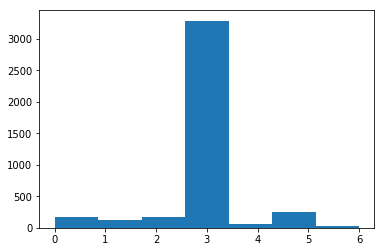

In [83]:
plt.hist(km.labels_, bins=num_clusters)
plt.show()

In [84]:

import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity

dist = 1 - cosine_similarity(tfidf_matrix)

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()

titles = list(map(lambda x: x.title, articles))
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

In [92]:
#set up colors per clusters using a dict
cluster_colors = {
    0: '#FFE981',
    1: '#BEEB9F',
    2: '#BBDED6',
    3: '#ffffff',
    4: '#F8B595',
    5: '#F67280',
    6: '#C06C84',
    7: '#6C5B7C',
    8: '#FFB6B9',
    9: '#FF9797',
}

#set up cluster names using a dict
cluster_names = {
    0: 'A', 
    1: 'B', 
    2: 'C', 
    3: 'D', 
    4: 'E',
    5: 'F',
    6: 'G',
    7: 'H',
    8: 'I',
    9: 'J',
}

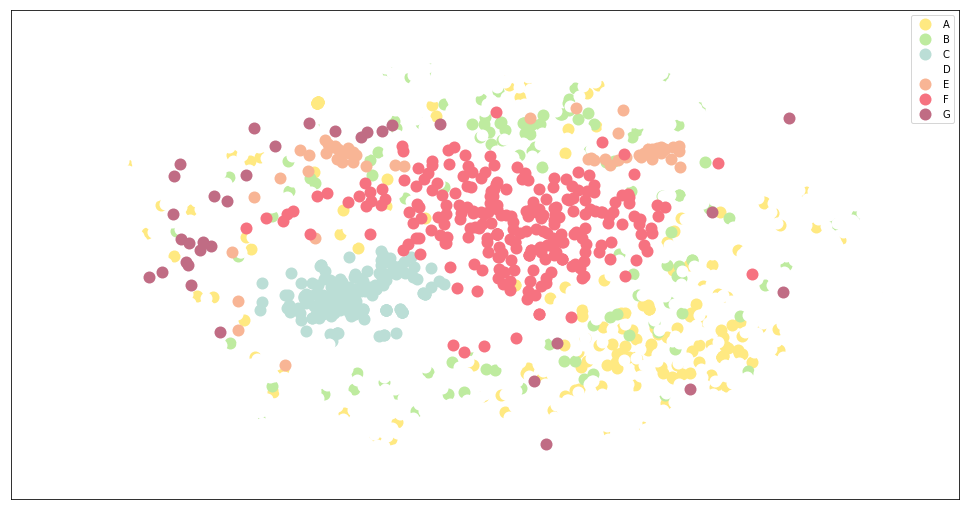

In [93]:
%matplotlib inline 
#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(
        group.x,
        group.y,
        marker='o',
        linestyle='',
        ms=12, 
        label=cluster_names[name],
        color=cluster_colors[name], 
        mec='none'
    )
    ax.set_aspect('auto')
    ax.tick_params(
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
#for i in range(len(df)):
#    ax.text(df.iloc[i]['x'], df.iloc[i]['y'], df.iloc[i]['title'], size=8)  

    
    
plt.show() #show the plot

In [87]:
print_cluster_terms()

Top terms per cluster:
Cluster 0:
eu hamilton red bulls home rudd windrush european uk brexit
Cluster 1:
amazon facebook deutsche inc schroepfer analytica cambridge microsoft bank street
Cluster 2:
korean kim north korea south moon jong un trump pyongyang
Cluster 3:
reuters china eikon london united new mr british england uk
Cluster 4:
cosby bill constand metoo mr andrea pennsylvania temple philadelphia mesereau
Cluster 5:
trump mr house donald white iran macron cohen jackson us
Cluster 6:
wembley khan fa nfl jaguars england fulham shahid jacksonville stadium
